In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from porespy import generators
from tomo_encoders.misc_utils.feature_maps_vis import view_midplanes
import cupy as cp
import time
import h5py
from tomopy import project
sys.path.append('/data02/MyArchive/aisteer_3Dencoders/TomoEncoders/tomo_encoders/tasks/sparse_segmenter/')
from recon_subvol import fbp_filter, recon_patch
from ct_segnet.data_utils.data_io import DataFile
import os
import signal
import tomocg as pt

In [2]:
# # Use managed memory
# cp.cuda.set_allocator(cp.cuda.MemoryPool(cp.cuda.malloc_managed).malloc)

### Generate data

In [3]:
fpath = '/data02/MyArchive/AM_part_Xuan/data/mli_L206_HT_650_L3_rec_1x1_uint16.hdf5'
ds = DataFile(fpath, data_tag = 'data', tiff = False, VERBOSITY = 0)

In [4]:
vol, s = ds.read_chunk(axis = 0, slice_start = 400, slice_end = 528)

array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

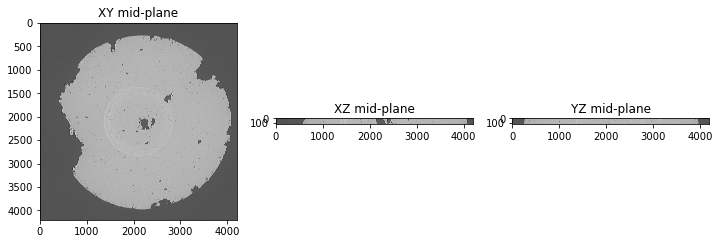

In [5]:
fig, ax = plt.subplots(1,3, figsize = (12,5))
view_midplanes(vol, ax = ax)

In [6]:
binning = 1
sbin = tuple([slice(None,None,binning)]*3)
vol = vol[sbin].copy()

In [7]:
vol = (vol - vol.min()) / (vol.max() - vol.min())

In [8]:
print(vol.max(), vol.min())

1.0 0.0


In [9]:
vol.shape

(128, 4200, 4200)

array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

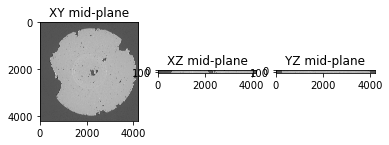

In [10]:
view_midplanes(vol)

In [11]:
padding = int(vol.shape[-1]*1/4.0)
padding = int(np.ceil(padding/4)*4)
#TO-DO # make sure the width of projection is divisible by four
vol = np.pad(vol, ((0,0),(padding,padding),(padding,padding)), mode = 'edge')

In [12]:
vol.shape

(128, 6304, 6304)

In [13]:
theta = np.linspace(0,np.pi,700//binning,dtype='float32')
ntheta = theta.size
nz = 128#vol.shape[0]
n = vol.shape[-1]
center = n/2.0
pnz = 4  # number of slices for simultaneous processing in tomography


r = nz//2 # 25 overlap because some border pixels are being missed by solver
s1 = slice(None,r,None)
s2 = slice(-r,None,None)
u0 = vol[s1] + 1j*vol[s2]
# u0 = vol+1j*0

ngpus=1
# Class gpu solver
t0 = time.time()
with pt.SolverTomo(theta, ntheta, r, n, pnz, center, ngpus) as slv:
    # generate data
    data = slv.fwd_tomo_batch(u0)
#     projs = data.real
    
    projs = np.zeros((ntheta, nz, n), dtype = 'float32')
    projs[:,s1,:] = data.real
    projs[:,s2,:] = data.imag
#     projs = data.real
    
projs = projs[:, :, padding:-padding]    
print("time %.4f"%(time.time()- t0))
print("projections shape: %s"%str(projs.shape))

# with h5py.File('tmp%i.hdf5'%binning, 'w') as hf:
#     hf.create_dataset('data', data = projs)
#     hf.create_dataset('theta', data = theta)
#     hf.create_dataset('center', data = center)
    
    

100%|██████████| 16/16 [00:29<00:00,  1.86s/it]


time 30.7868
projections shape: (700, 128, 4200)


In [14]:
# binning = 2
# with h5py.File('tmp%i.hdf5'%binning, 'r') as hf:
#     projs = np.asarray(hf['data'][:])
#     theta = np.asarray(hf['theta'][:])
#     center = float(np.asarray(hf['center'][()]))

projections shape: (700, 128, 4200)


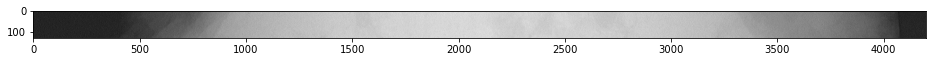

In [15]:
print("projections shape: %s"%str(projs.shape))

fig, ax = plt.subplots(1,1, figsize = (16,8))
ax.imshow(projs[0], cmap = 'gray')

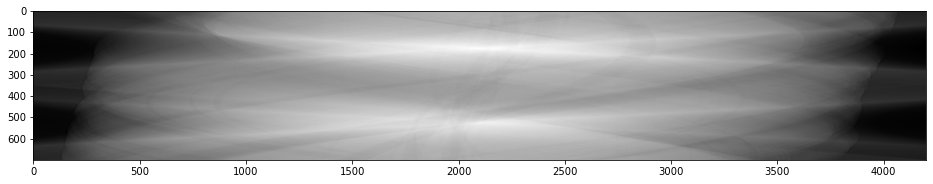

In [16]:
fig, ax = plt.subplots(1,1, figsize = (16,8))
ax.imshow(projs[:,0,:], cmap = 'gray')

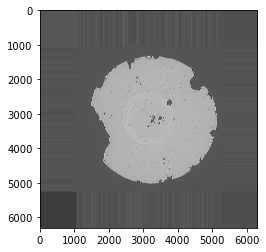

In [17]:
plt.imshow(vol.take(0, axis = 0), cmap = 'gray')

### Reconstruct part

In [18]:
binning

1

## Reconstruct one full slice  

In [19]:
projs.shape

(700, 128, 4200)

In [20]:
projs.shape

(700, 128, 4200)

In [21]:
binning

1

In [22]:
projs.shape

(700, 128, 4200)

In [23]:
# cp.get_default_memory_pool().free_all_blocks()


In [24]:
# point = [500//binning, 0, 0]
# point = [0, 0, 0]
# width = [1, 4200//binning, 4200//binning]


# z, y, x
# point = [0, 2000//binning, 2000//binning]
# width = [128, 512, 512]

point = [0, 0, 0]
width = [128, 2100, 2100]


with cp.cuda.Device(0):
    center = projs.shape[-1]//2.0
    sub_vol = recon_patch(projs, theta, center, point, width, mem_limit_gpu = 40.0, apply_fbp=True)
    sub_vol = 1.0*(sub_vol - sub_vol.min()) / (sub_vol.max() - sub_vol.min())

(700, 128, 6304)
2.6157240867614746


In [25]:
sub_vol.shape

(128, 2100, 2100)

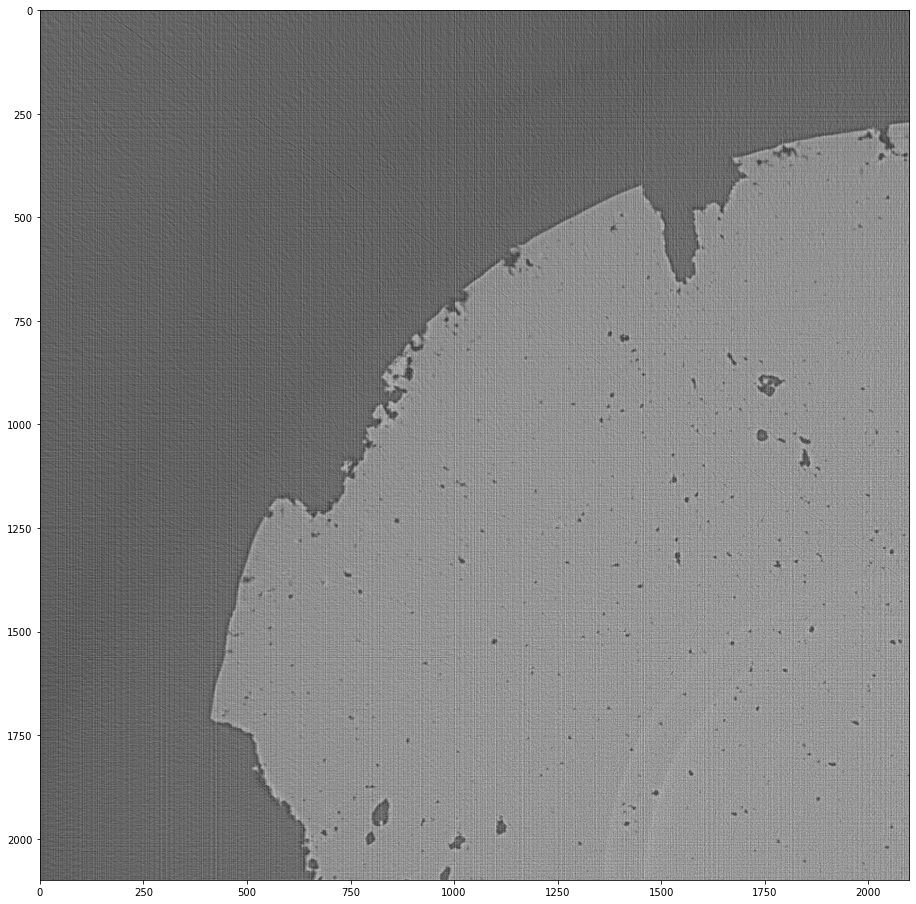

In [26]:
fig, ax = plt.subplots(1,1, figsize = (16,16))
ax.imshow(sub_vol[0], cmap = 'gray')

### Reconstruct slabs  

In [16]:
# point is the corner value z, y, x and width is the width of box. this will be fed from detection part
point = [400//binning, 2000//binning, 2000//binning]
width = [128//binning, 256//binning, 256//binning]
vol.shape

(551, 2100, 2100)

In [17]:
sub_vol = recon_patch(projs, theta, center, point, width, mem_limit_gpu = 40.0)

0.03810310363769531


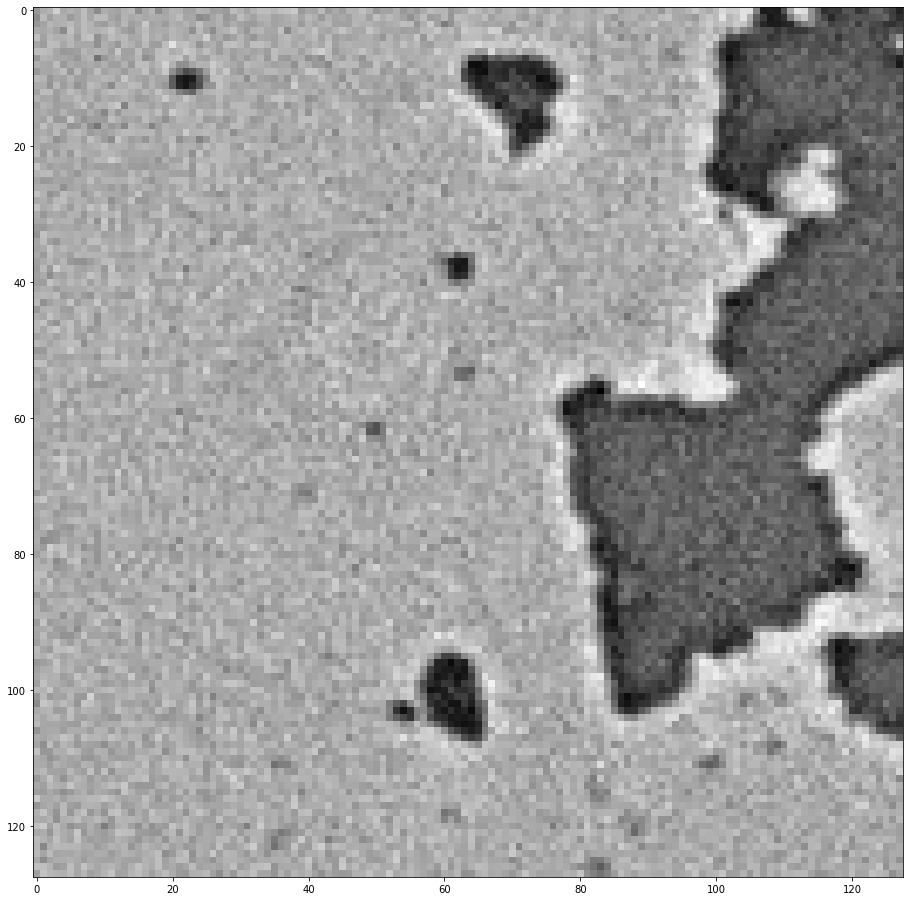

In [18]:
fig, ax = plt.subplots(1,1, figsize = (16,16))
ax.imshow(sub_vol[0], cmap = 'gray')

In [19]:
sub_vol.shape

(64, 128, 128)

array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

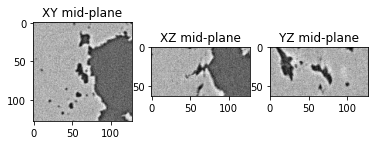

In [20]:
view_midplanes(sub_vol)

### Reconstruct cube  

In [21]:
# point is the corner value z, y, x and width is the width of box. this will be fed from detection part
point = [400//binning, 2000//binning, 2000//binning]
width = [256//binning, 256//binning, 256//binning]
vol.shape

(551, 2100, 2100)

In [22]:
sub_vol = recon_patch(projs, theta, center, point, width, mem_limit_gpu = 40.0)
# sub_vol = 2.0*(sub_vol - sub_vol.min()) / (sub_vol.max() - sub_vol.min())

0.07354521751403809


array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

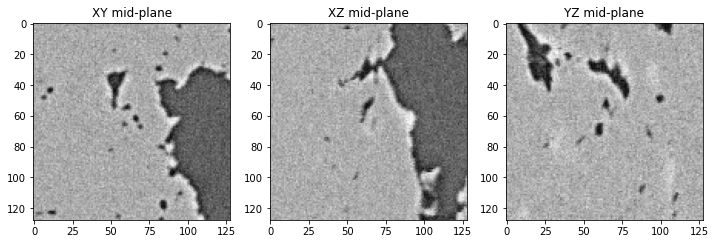

In [23]:
fig, ax = plt.subplots(1, 3, figsize = (12,6))
view_midplanes(sub_vol, ax = ax)

In [24]:
# slices = tuple([slice(point[ii], point[ii] + width[ii]) for ii in range(3)])
# vol[slices] = sub_vol

In [25]:
# fig, ax = plt.subplots(1, 3, figsize = (12,6))
# view_midplanes(vol, ax = ax, idxs = [point[j] + width[j]//2 for j in range(3)])

## TRASHED  

In [26]:
# CHECK PROJECTIONS
# theta_vals = np.random.choice(theta, 16, replace = True)
# fig, ax = plt.subplots(2,2, figsize = (16,8))
# fig.suptitle('binning = %i'%binning, fontsize = 24)
# for ii in range(4):
#     idx = np.argmin(np.abs(theta_vals[ii] - theta))
#     ax.flat[ii].imshow(projs[idx], cmap = 'gray')
#     ax.flat[ii].set_title('theta = %.3f'%theta_vals[ii])    
#     print(f'error={cp.linalg.norm(projs1[::2,::2,::2]-projs2)/cp.linalg.norm(projs2)}')
    
# fig.tight_layout()